In [1]:
import os, gc
os.environ["CUDA_VISIBLE_DEVICES"]="0"
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn.functional as F
import copy
import math
import cv2

from PIL import Image


# IF THIS EQUALS NONE, THEN WE TRAIN NEW MODELS
# IF THIS EQUALS DISK PATH, THEN WE LOAD PREVIOUSLY TRAINED MODELS
LOAD_MODELS_FROM = None

USE_KAGGLE_SPECTROGRAMS = True
USE_EEG_SPECTROGRAMS = False
NUM_CLASSES=6
BATCH_SIZE = 16
LR = 0.001
device = torch.device('cuda:0' if torch.cuda.is_available else 'cpu')
print(device)

cuda:0


In [2]:
df = pd.read_csv('./train.csv')
TARGETS = df.columns[-6:]
print('Train shape:', df.shape )
print('Targets', list(TARGETS))
df.head()

Train shape: (106800, 15)
Targets ['seizure_vote', 'lpd_vote', 'gpd_vote', 'lrda_vote', 'grda_vote', 'other_vote']


,eeg_id,eeg_sub_id,eeg_label_offset_seconds,spectrogram_id,spectrogram_sub_id,spectrogram_label_offset_seconds,label_id,patient_id,expert_consensus,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote
0,1628180742,0,0.0,353733,0,0.0,127492639,42516,Seizure,3,0,0,0,0,0
1,1628180742,1,6.0,353733,1,6.0,3887563113,42516,Seizure,3,0,0,0,0,0
2,1628180742,2,8.0,353733,2,8.0,1142670488,42516,Seizure,3,0,0,0,0,0
3,1628180742,3,18.0,353733,3,18.0,2718991173,42516,Seizure,3,0,0,0,0,0
4,1628180742,4,24.0,353733,4,24.0,3080632009,42516,Seizure,3,0,0,0,0,0


In [3]:
train = df.groupby('eeg_id')[['spectrogram_id','spectrogram_label_offset_seconds']].agg(
    {'spectrogram_id':'first','spectrogram_label_offset_seconds':'min'})
train.columns = ['spectrogram_id','min']

tmp = df.groupby('eeg_id')[['spectrogram_id','spectrogram_label_offset_seconds']].agg(
    {'spectrogram_label_offset_seconds':'max'})
train['max'] = tmp

tmp = df.groupby('eeg_id')[['patient_id']].agg('first')
train['patient_id'] = tmp

tmp = df.groupby('eeg_id')[TARGETS].agg('sum')
for t in TARGETS:
    train[t] = tmp[t].values
    
y_data = train[TARGETS].values
y_data = y_data / y_data.sum(axis=1,keepdims=True)
train[TARGETS] = y_data

tmp = df.groupby('eeg_id')[['expert_consensus']].agg('first')
train['target'] = tmp

train = train.reset_index()
print('Train non-overlapp eeg_id shape:', train.shape )
train.head()

Train non-overlapp eeg_id shape: (17089, 12)


,eeg_id,spectrogram_id,min,max,patient_id,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote,target
0,568657,789577333,0.0,16.0,20654,0.0,0.000000,0.25,0.000000,0.166667,0.583333,Other
1,582999,1552638400,0.0,38.0,20230,0.0,0.857143,0.00,0.071429,0.000000,0.071429,LPD
2,642382,14960202,1008.0,1032.0,5955,0.0,0.000000,0.00,0.000000,0.000000,1.000000,Other
3,751790,618728447,908.0,908.0,38549,0.0,0.000000,1.00,0.000000,0.000000,0.000000,GPD
4,778705,52296320,0.0,0.0,40955,0.0,0.000000,0.00,0.000000,0.000000,1.000000,Other


In [4]:
print(type(train))

<class 'pandas.core.frame.DataFrame'>


In [5]:
%%time
READ_SPEC_FILES = False

# READ ALL SPECTROGRAMS
PATH = './train_spectrograms/'
files = os.listdir(PATH)
print(f'There are {len(files)} spectrogram parquets')

if READ_SPEC_FILES:    
    spectrograms = {}
    for i,f in enumerate(files):
        if i%100==0: print(i,', ',end='')
        tmp = pd.read_parquet(f'{PATH}{f}')
        name = int(f.split('.')[0])
        spectrograms[name] = tmp.iloc[:,1:].values
else:
    spectrograms = np.load('./preprocessed_spectro/specs.npy',allow_pickle=True).item()

There are 11138 spectrogram parquets
CPU times: total: 812 ms
Wall time: 10.1 s


In [6]:
import albumentations as albu
TARS = {'Seizure':0, 'LPD':1, 'GPD':2, 'LRDA':3, 'GRDA':4, 'Other':5}
TARS2 = {x:y for y,x in TARS.items()}

class myDataset(torch.utils.data.Dataset):
    'Generates data for pytorch'
    def __init__(self, data, batch_size=16, shuffle=False, augment=False, mode='train',
                 specs = spectrograms): 

        self.data = data
        self.shuffle = shuffle
        self.augment = augment
        self.mode = mode
        self.specs = specs
        # self.eeg_specs = eeg_specs
        # self.on_epoch_end()
        
    def __len__(self):
        'Denotes the number of batches per epoch'
        l = len(self.data)
        return l

    def __getitem__(self, index):
        'Generate one batch of data'
        # indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        X, y = self.__data_generation(index)
        if self.augment: 
            X = self.__augment_batch(X) 
        return torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

    # def on_epoch_end(self):
    #     'Updates indexes after each epoch'
    #     self.indexes = np.arange( len(self.data) )
    #     if self.shuffle: np.random.shuffle(self.indexes)
                        
    def __data_generation(self, index):
        'Generates data containing batch_size samples' 
        X = np.zeros((128,256,8),dtype='float32')
        y = np.zeros(6,dtype='float32')
        img = np.ones((128,256),dtype='float32')
        

        row = self.data.iloc[index]
        # print(row)
        if self.mode=='test': 
            r = 0
        else: 
            r = int( (row['min'] + row['max'])//4 )

        for k in range(4):
            # EXTRACT 300 ROWS OF SPECTROGRAM
            img = self.specs[row.spectrogram_id][r:r+300,k*100:(k+1)*100].T
            
            # LOG TRANSFORM SPECTROGRAM
            img = np.clip(img,np.exp(-4),np.exp(8))
            img = np.log(img)
            
            # STANDARDIZE PER IMAGE
            ep = 1e-6
            m = np.nanmean(img.flatten())
            s = np.nanstd(img.flatten())
            img = (img-m)/(s+ep)
            img = np.nan_to_num(img, nan=0.0)
            
            # CROP TO 256 TIME STEPS
            # print("X.shape",X.shape) # (batch_size, h, w, c)
            X[14:-14,:,k] = img[:,22:-22] / 2.0
    
        # EEG SPECTROGRAMS
        # img = self.eeg_specs[row.eeg_id]
        # X[j,:,:,4:] = img
            
        if self.mode!='test':
            y = row[TARGETS]
        
        return X,y
    
    # def __random_transform(self, img):
    #     composition = albu.Compose([
    #         albu.HorizontalFlip(p=0.5),
    #         #albu.CoarseDropout(max_holes=8,max_height=32,max_width=32,fill_value=0,p=0.5),
    #     ])
    #     return composition(image=img)['image']
            
    # def __augment_batch(self, img_batch):
    #     for i in range(img_batch.shape[0]):
    #         img_batch[i, ] = self.__random_transform(img_batch[i, ])
    #     return img_batch

C:\Users\zhouyu\AppData\Local\Temp\ipykernel_45352\3230772547.py:29: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)


X shape: torch.Size([128, 256, 8])
y shape: torch.Size([6])


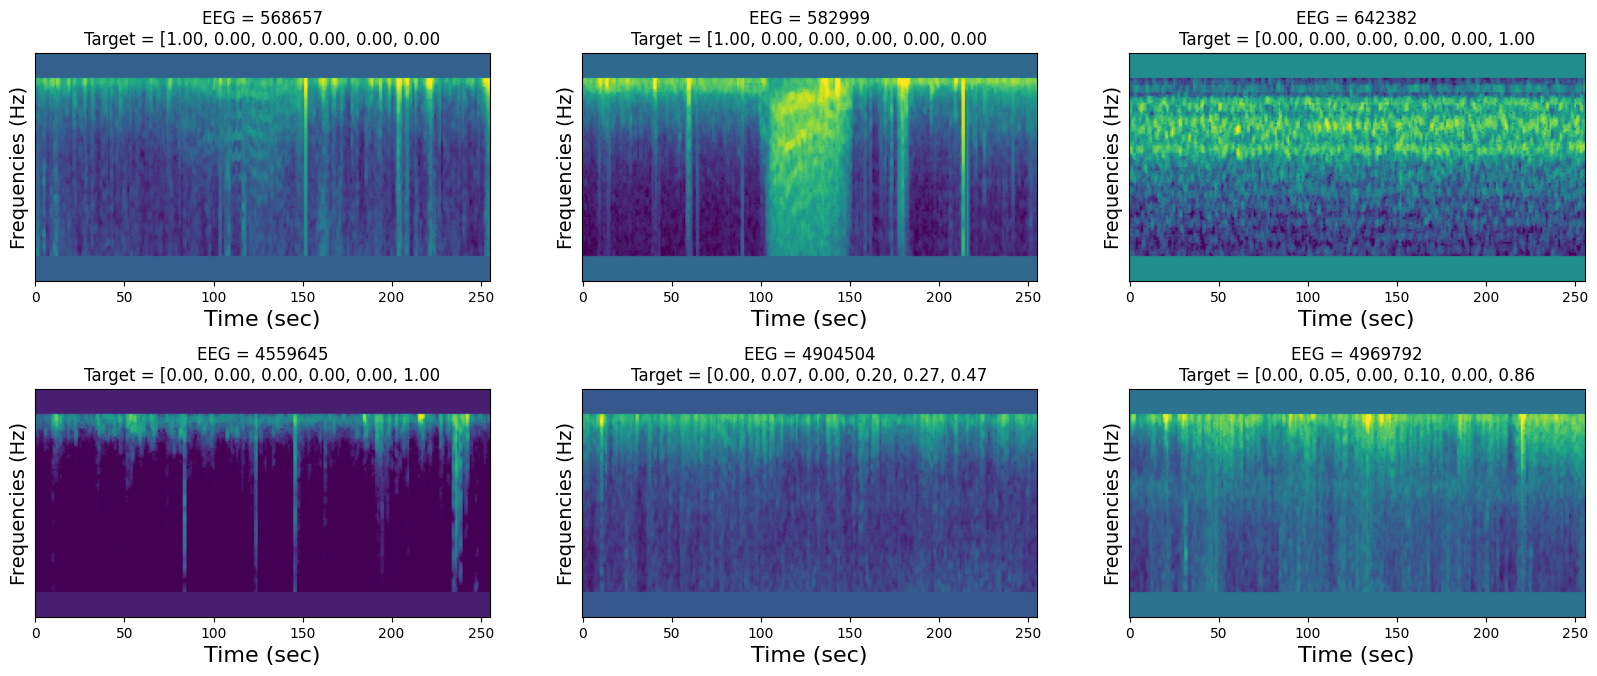

In [7]:
train_dataset = myDataset(train, batch_size=16, mode="train")
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=True
)
X, y = train_dataset[0]
print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")


ROWS = 2
COLS = 3
for (X, y) in train_loader:
    plt.figure(figsize=(20,8))
    for row in range(ROWS):
        for col in range(COLS):
            plt.subplot(ROWS, COLS, row*COLS + col+1)
            t = y[row*COLS + col]
            img = X[row*COLS + col, :, :, 0]
            mn = img.flatten().min()
            mx = img.flatten().max()
            img = (img-mn)/(mx-mn)
            plt.imshow(img)
            tars = f'[{t[0]:0.2f}'
            for s in t[1:]:
                tars += f', {s:0.2f}'
            eeg = train.eeg_id.values[row*BATCH_SIZE + row*COLS + col]
            plt.title(f'EEG = {eeg}\nTarget = {tars}',size=12)
            plt.yticks([])
            plt.ylabel('Frequencies (Hz)',size=14)
            plt.xlabel('Time (sec)',size=16)
    plt.show()
    break


In [8]:
class myModel(nn.Module):
    def __init__(self, pretrained_model, num_classes: int = 6, pretrained: bool = True):
        super().__init__()
        self.USE_KAGGLE_SPECTROGRAMS = True
        self.USE_EEG_SPECTROGRAMS = True
        self.model = pretrained_model
        self.model.fc.out_features = num_classes

        self.features = nn.Sequential(*list(self.model.children())[:-2])

        # self.custom_layers = nn.Sequential(
        #     nn.AdaptiveAvgPool2d(1),
        #     nn.Flatten(),
        #     nn.Linear(self.model.fc.out_features, num_classes)
        # )


    def __reshape_input(self, x):
        """
        Reshapes input (128, 256, 8) -> (512, 512, 3) monotone image.
        """ 
        # === Get spectograms ===
        # print("input shape is:", x.shape)
        spectograms = [x[:, :, :, i:i+1] for i in range(4)]
        spectograms = torch.cat(spectograms, dim=1)
        
        # === Get EEG spectograms ===
        eegs = [x[:, :, :, i:i+1] for i in range(4,8)]
        eegs = torch.cat(eegs, dim=1)
        
        # === Reshape (512,512,3) ===
        if self.USE_KAGGLE_SPECTROGRAMS & self.USE_EEG_SPECTROGRAMS:
            x = torch.cat([spectograms, eegs], dim=2)
        elif self.USE_EEG_SPECTROGRAMS:
            x = eegs
        else:
            x = spectograms
            
        x = torch.cat([x,x,x], dim=3)
        x = x.permute(0, 3, 1, 2)
        desired_size = (64, 64) 
        x = F.interpolate(x, size=desired_size, mode='bilinear', align_corners=False)
        
        # print("after reshape:", x.shape)
        return x
    
    def forward(self, x):
        x = self.__reshape_input(x)
        # x = self.features(x)
        x = self.model(x)
        # print('before custom layers, shape is:',x.shape)
        # x = self.custom_layers(x)
        return x

In [9]:
# choose model
# download the pretrained neural network model ResNet-50
# initally has the pretrained ImageNet weights
resnet152 = models.resnet152(pretrained=True)

num_ftrs = resnet152.fc.in_features

resnet152.fc = nn.Linear(num_ftrs, NUM_CLASSES)

model = myModel(resnet152)
# model = nn.Sequential(
#     resnet50,
#     nn.Softmax(dim=1)
# )

# for param in model.parameters():
#     # set to true when we want to train the model (update the weights)
#     param.requires_grad = True

# for param in model.fc.parameters():
#     param.requires_grad = True
model = model.to(device)


C:\Users\zhouyu\anaconda3\envs\cs4487\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\zhouyu\anaconda3\envs\cs4487\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [10]:
# choose optimizer
# use SGD with momentum as optimizier
# set weight_decay to prevent overfitting
# optimizer_conv = optim.Adam(model.parameters(),
#                            lr=learning_rate)
optimizer_conv = optim.SGD(model.parameters(),
                           lr=LR, momentum=0.9, weight_decay=0.0005)

# use cosine warm restart learning rate scheduler, restart every 5 epochs
scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=5, gamma=0.1)


In [12]:
# create the train model function
# model = model.zero_grad()
from sklearn.model_selection import KFold, GroupKFold

train_loss_values = []
val_loss_values = []

def train_model(model, criterion, optimizer, scheduler, num_epochs=2, checkpoint=None):
    

    outputlist = {'train': {'loss': [], 'acc': []},
                  'valid': {'loss': [], 'acc': []}, 'lr': []}
    # print('checkpoint:',checkpoint)

    if checkpoint is None:
        # print(next(model.parameters()).device)
        # print(model.state_dict()=='')
        best_model_wts = copy.deepcopy(model.state_dict())
        best_loss = math.inf
        best_acc = 0.
    else:
        print(
            f'Val loss: {checkpoint["best_val_loss"]}, Val accuracy: {checkpoint["best_val_accuracy"]}')
        model.load_state_dict(checkpoint['model_state_dict'])
        best_model_wts = copy.copy(model.state_dict())
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
        best_loss = checkpoint['best_val_loss']
        best_acc = checkpoint['best_val_accuracy']

    # start
    gkf = GroupKFold(n_splits=2)
    for i, (train_index, valid_index) in enumerate(gkf.split(train, train.target, train.patient_id)):  
        # print(train_index)
        train_dataset = myDataset(train.iloc[train_index])
        valid_dataset = myDataset(train.iloc[valid_index])
        train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
        valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False)
        dataloaders = {'train':train_loader, 'valid':valid_loader}
        
        print('#'*25)
        print(f'### Fold {i+1}')


        for epoch in range(1, num_epochs+1):
            print('Epoch {}/{}'.format(epoch, num_epochs))
            print('--' * 10)
    
            # record the learning rate in each epoch
            outputlist['lr'].append(optimizer.param_groups[0]['lr'])
            # print(outputlist)


        
            # Each epoch has a training and validation phase
            for phase in ['train', 'valid']:
                # print(phase)
                running_loss = 0.0
                running_corrects = 0
                # Iterate over data
                for i, (inputs, labels) in enumerate(dataloaders[phase]):
                    inputs = inputs.to(device)
                    labels = labels.to(device)
                    # print(inputs, labels)
    
                    # zero the parameter gradients
                    optimizer.zero_grad()
    
                    # forward propogation
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)

                        # _, pred_classes = torch.max(outputs, dim=1)
                                                
                        labels = labels.float()
    
                        loss = criterion(outputs, labels)
                        # loss.requires_grad=True
                        if phase=='train':
                            train_loss_values.append(loss)
                        else:
                            val_loss_values.append(loss)
    
                        # backward propogation and optimize in 'train' mode
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()
    
                    # statistics
                    running_loss += loss.item()

    
                if phase == 'train':
                    scheduler.step()
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode
    
                epoch_loss = running_loss / len(train_dataset) if phase=='train' else running_loss / len(valid_dataset)
                # record the loss and accuracy for visualization
                outputlist[phase]['loss'].append(epoch_loss)
    
                print('{} Loss: {:.4f}'.format(
                    phase, epoch_loss))
    
                # deep copy the best model
                if phase == 'valid' and epoch_loss < best_loss:
                    print(f'New best model found!')
                    print(
                        f'New record loss: {epoch_loss}, Previous record loss: {best_loss}')
                    best_loss = epoch_loss
                    # best_acc = epoch_acc
                    best_model_wts = copy.deepcopy(model.state_dict())

    print('Best val loss: {:.4f}'.format(
         best_loss))

    # load and return the best model weights
    model.load_state_dict(best_model_wts)
    return model, best_loss, outputlist


In [13]:
# start training!
# BEGIN TRAINING PROCESS
# calling the training function to train pre-trained ResNet50
epochs = 10


model, best_val_loss, outputlist = train_model(model,          nn.CrossEntropyLoss(),
                                                                  optimizer_conv,
                                                                  scheduler,
                                                                  num_epochs=epochs)

# save the checkpoint to this path
model_name = type(model).__name__
check_point_path = f"checkpoint-{model_name}.pth"

torch.save({'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer_conv.state_dict(),
            'best_val_loss': best_val_loss,
            'scheduler_state_dict': scheduler.state_dict(),
            }, check_point_path)


#########################
### Fold 1
Epoch 1/10
--------------------


C:\Users\zhouyu\AppData\Local\Temp\ipykernel_45352\3230772547.py:29: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)


train Loss: 0.0887
valid Loss: 0.0912
New best model found!
New record loss: 0.09123485794954651, Previous record loss: inf
Epoch 2/10
--------------------
train Loss: 0.0776
valid Loss: 0.0928
Epoch 3/10
--------------------
train Loss: 0.0719
valid Loss: 0.0948
Epoch 4/10
--------------------
train Loss: 0.0673
valid Loss: 0.0954
Epoch 5/10
--------------------
train Loss: 0.0636
valid Loss: 0.0960
Epoch 6/10
--------------------
train Loss: 0.0525
valid Loss: 0.0921
Epoch 7/10
--------------------
train Loss: 0.0494
valid Loss: 0.0902
New best model found!
New record loss: 0.0902138801957516, Previous record loss: 0.09123485794954651
Epoch 8/10
--------------------
train Loss: 0.0464
valid Loss: 0.0891
New best model found!
New record loss: 0.08912374275061316, Previous record loss: 0.0902138801957516
Epoch 9/10
--------------------
train Loss: 0.0434
valid Loss: 0.0894
Epoch 10/10
--------------------
train Loss: 0.0402
valid Loss: 0.0897
#########################
### Fold 2
Epoch 

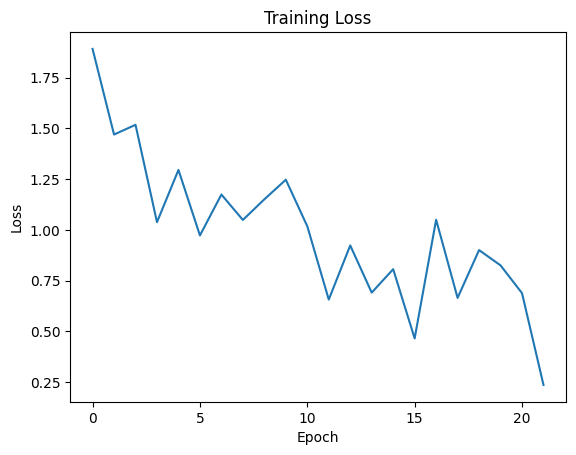

In [14]:
loss_array = [train_loss_values[i].cpu().detach().numpy() for i in range(0, len(train_loss_values)//2-1, 250)]

plt.plot(loss_array)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()